In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [7]:
LABEL_TYPE = 'actual' # 'actual' or 'predicted'
if LABEL_TYPE == 'actual':
    PATH_DATASET = '../protocols/labelled/massnahmen_relevant.csv'
elif LABEL_TYPE == 'predicted':
    PATH_DATASET = '../protocols/labelled/massnahmen_relevant_bert_predictions.csv'
PATH_OPINIONS_PER_PARTY = f'../results/opinion_measures_{LABEL_TYPE}_per_party_big.png'
PATH_OPINION_CONS_PER_PARTY = f'../results/opinion_measures_{LABEL_TYPE}_consistency_over_time_per_party.png'
PATH_OPINIONS_PER_SPEAKER = f'../results/opinion_measures_{LABEL_TYPE}_per_speaker.png'
PATH_OPINION_CONS_PER_SPEAKER = f'../results/opinion_measures_{LABEL_TYPE}_consistency_over_time_per_speaker.png'

In [8]:
data = pd.read_csv(PATH_DATASET, sep='\t')
data.sort_values('Date', inplace=True)
data["opinion_integer"] = 0
data.loc[data['Opinion'] == '-', "opinion_integer"] = 0
data.loc[data['Opinion'] == 'o', "opinion_integer"] = 1
data.loc[data['Opinion'] == '+', "opinion_integer"] = 2
data.head()
dates = data['Date'].unique()
parties = data['Party'].unique()
speakers = data['speaker_name'].unique()
speakers.sort()

In [9]:
parties = ['Grüne','ÖVP','FPÖ','NEOS','SPÖ']

In [10]:
opinions_per_party = {}
opinions_per_party_rel = {}
for party in parties:
    data_party = data[data['Party'] == party]
    opinion_counts = np.bincount(data_party['opinion_integer'], minlength=3)
    opinions_per_party[party] = opinion_counts
    opinions_per_party_rel[party] = opinion_counts / opinion_counts.sum()

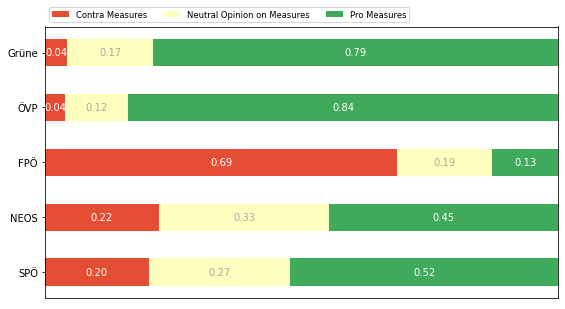

In [11]:
category_names = ["Contra Measures", "Neutral Opinion on Measures", "Pro Measures"]
results = opinions_per_party

def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, fmt='%.2f', label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(opinions_per_party_rel, category_names)
plt.savefig(PATH_OPINIONS_PER_PARTY)
plt.show()

In [16]:
opinions_per_party_day = {party: [] for party in parties}
for date in dates:
    data_day = data[data['Date'] == date]

    for party in parties:
        data_day_party = data_day[data_day['Party'] == party]
        opinion_counts = np.bincount(data_day_party['opinion_integer'], minlength=3)
        opinions_per_party_day[party].append(opinion_counts)

opinion_consistency_per_party = {party: [] for party in parties}
for party in parties:
    opinions_per_day = opinions_per_party_day[party]
    cumulative_opinions = np.array([0,0,0])
    opinion_consistencies = []
    for opinions in opinions_per_day:
        cumulative_opinions += opinions
        opinion_consistency = cumulative_opinions[[0,2]].max() / cumulative_opinions[[0,2]].sum()
        opinion_consistencies.append(opinion_consistency)
    opinion_consistency_per_party[party] = opinion_consistencies

<ipython-input-16-b81f17b5d90f>:17: RuntimeWarning: invalid value encountered in long_scalars
  opinion_consistency = cumulative_opinions[[0,2]].max() / cumulative_opinions[[0,2]].sum()


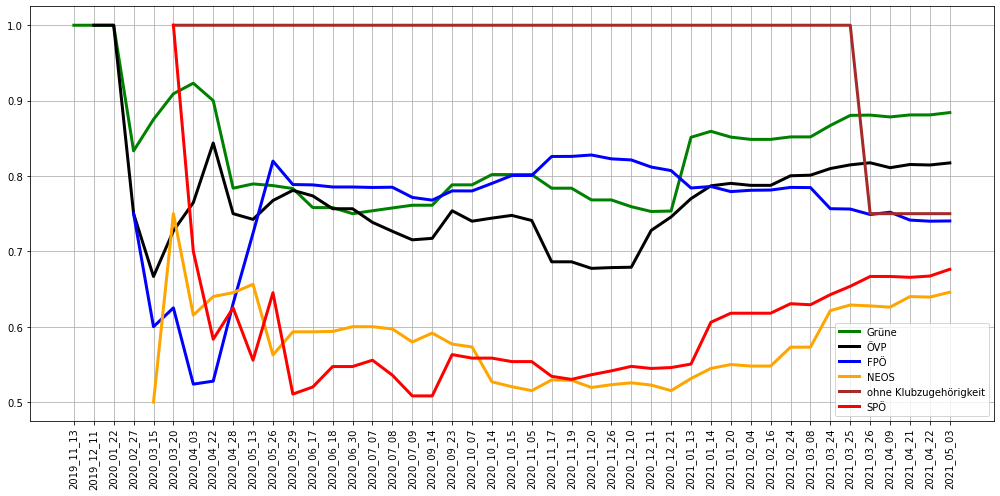

In [17]:
fig, ax = plt.subplots(figsize=(14, 7))

colors = {
    'SPÖ': 'red',
    'ÖVP': 'black',
    'NEOS': 'orange',
    'Grüne': 'green',
    'FPÖ': 'blue',
    'ohne Klubzugehörigkeit': 'brown'
}
for party in parties:
    ax.plot(dates, opinion_consistency_per_party[party], label=party, color=colors[party], linewidth=3)
plt.xticks(dates, dates, rotation='vertical')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PATH_OPINION_CONS_PER_PARTY)
plt.show()

In [18]:
opinions_per_speaker = []
# opinions per speaker
for speaker in speakers:
    opinions = np.bincount(data[data['speaker_name'] == speaker]['opinion_integer'], minlength=3)
    opinions_per_speaker.append((speaker, opinions))
opinions_per_speaker.sort(key = lambda x: sum(x[1]), reverse=True)


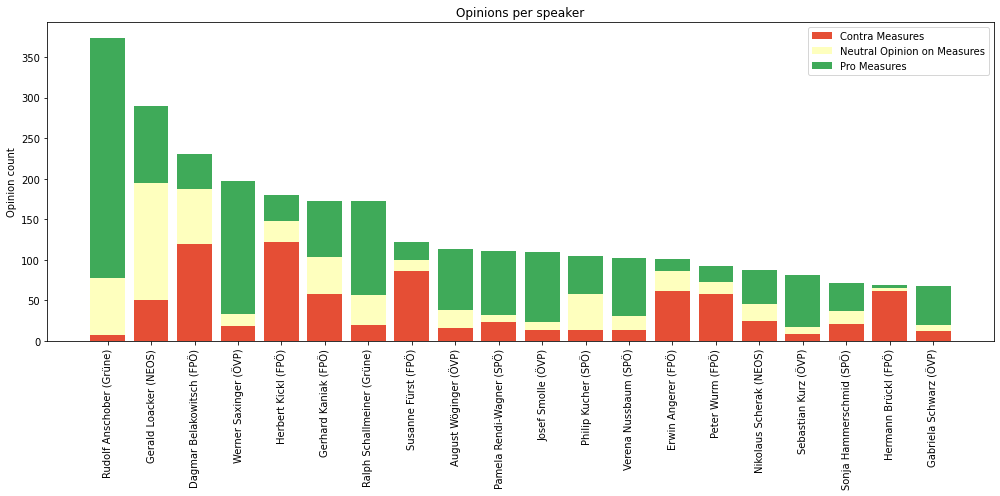

In [19]:
category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, 3))
speaker_party = {speaker: data[data['speaker_name'] == speaker]['Party'].tolist()[0] for speaker in speakers}

top_n_speakers = 20
labels = [f'{tple[0]} ({speaker_party[tple[0]]})' for tple in opinions_per_speaker[:top_n_speakers]]
neg = [tple[1][0] for tple in opinions_per_speaker[:top_n_speakers]]
neut = [tple[1][1] for tple in opinions_per_speaker[:top_n_speakers]]
pos = [tple[1][2] for tple in opinions_per_speaker[:top_n_speakers]]

width = 0.8       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(14, 7))

ax.bar(labels, neg, width, label='Contra Measures', color=category_colors[0])
ax.bar(labels, neut, width, bottom=neg, label='Neutral Opinion on Measures', color=category_colors[1])
ax.bar(labels, pos, width, bottom=np.array(neut)+np.array(neg), label='Pro Measures', color=category_colors[2])

ax.set_ylabel('Opinion count')
ax.set_title('Opinions per speaker')
ax.legend()
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig(PATH_OPINIONS_PER_SPEAKER)
plt.show()

In [20]:
selected_speakers = ['Rudolf Anschober', 'Gerald Loacker', 'Herbert Kickl', 'Pamela Rendi-Wagner', 'Sebastian Kurz']

opinions_per_speaker_day = {speaker: [] for speaker in selected_speakers}
for date in dates:
    data_day = data[data['Date'] == date]

    for speaker_name in selected_speakers:
        data_day_speaker = data_day[data_day['speaker_name'] == speaker_name]
        opinion_counts = np.bincount(data_day_speaker['opinion_integer'], minlength=3)
        opinions_per_speaker_day[speaker_name].append(opinion_counts)

opinion_consistency_per_speaker = {speaker: [] for speaker in selected_speakers}
for speaker_name in selected_speakers:
    opinions_per_day = opinions_per_speaker_day[speaker_name]
    cumulative_opinions = np.array([0,0,0])
    opinion_consistencies = []
    for opinions in opinions_per_day:
        cumulative_opinions += opinions
        opinion_consistency = cumulative_opinions[[0,2]].max() / cumulative_opinions[[0,2]].sum()
        opinion_consistencies.append(opinion_consistency)
    opinion_consistency_per_speaker[speaker_name] = opinion_consistencies

<ipython-input-20-169a6f580373>:19: RuntimeWarning: invalid value encountered in long_scalars
  opinion_consistency = cumulative_opinions[[0,2]].max() / cumulative_opinions[[0,2]].sum()


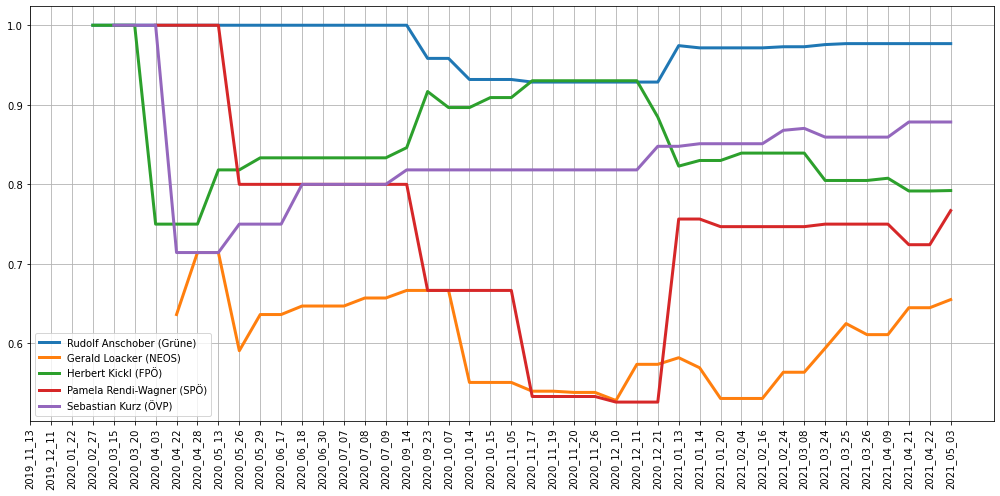

In [21]:
fig, ax = plt.subplots(figsize=(14, 7))

# colors = {
#     'SPÖ': 'red',
#     'ÖVP': 'black',
#     'NEOS': 'orange',
#     'Grüne': 'green',
#     'FPÖ': 'blue',
#     'ohne Klubzugehörigkeit': 'brown'
# }
for speaker in selected_speakers:
    ax.plot(dates, opinion_consistency_per_speaker[speaker], label=f'{speaker} ({speaker_party[speaker]})', linewidth=3)
plt.xticks(dates, dates, rotation='vertical')
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PATH_OPINION_CONS_PER_SPEAKER)
plt.show()